# Topic Analysis

With trained topic models and a Joint-KNN representation of the data, we can analyze the topics to understand the regulatory dynamics present within a sample. Expression topics may be analyzed with functional enrichments of the top genes activated in a given topic/module. Accessibility topics correspond to a set of coordinated *cis*-regulatory elements, and may be analyzed to find emergent transcription factor regulators of particular cell states.

This tutorial will cover predicting factor binding and analyzing topic modules in both modes. First, we import packages:

In [1]:
import mira
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import logging
import warnings
warnings.simplefilter("ignore")
mira.utils.pretty_sderr()

Download the SHARE-seq skin data (if not already downloaded), and load the SHARE-seq data and topic models:

In [2]:
mira.datasets.ShareseqSkin_Ma2020()
rna_data = anndata.read_h5ad('mira-datasets/shareseq_Ma2020/rna_data.joint_representation.h5ad')
atac_data = anndata.read_h5ad('mira-datasets/shareseq_Ma2020/atac_data.joint_representation.h5ad')

rna_model = mira.topics.ExpressionTopicModel.load('mira-datasets/shareseq_Ma2020/rna_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('mira-datasets/shareseq_Ma2020/atac_model.pth')

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* rna_data.joint_representation.rp_modeled.h5ad
	* hair_follicle.h5ad
	* rna_data.joint_representation.h5ad
	* atac_data.joint_representation.h5ad
	* atac_model.pth
	* atac_data.h5ad
	* atac_data.joint_representation.motif_calls.tss_annotated.h5ad
	* atac_data.joint_representation.motif_calls.h5ad
	* rna_model.pth
	* rna_data.h5ad
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
atac_model.encoder.calc_readdepth = False

We pick up from the previous tutorial, making the **joint representation**, in which we constructed a UMAP view of the data. We can visualize the flow of topics to illustrate how they captured aspects of the differentiation process. For instance, we can plot expression topics 6 and 13, which mark matrix cells of the hair follicle and granular cells of the epidermis, respectively:

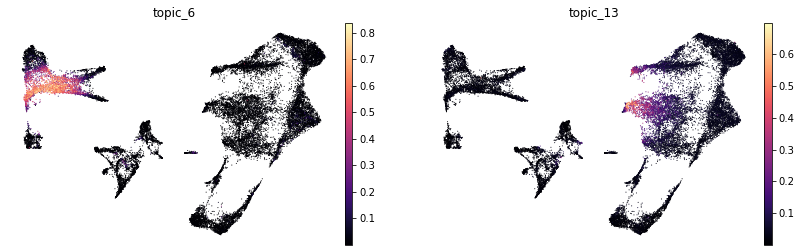

In [4]:
sc.pl.umap(rna_data, color  = ['topic_6', 'topic_13'], frameon=False, ncols=2,
          color_map = 'magma')

## Expression Topic Analysis

We can plot expression patterns of genes that are activated by these topics. To get the top genes associated with a topic:

In [5]:
rna_model.get_top_genes(6, top_n=2)

array(['EDARADD', 'SHH'], dtype=object)

And plotting:

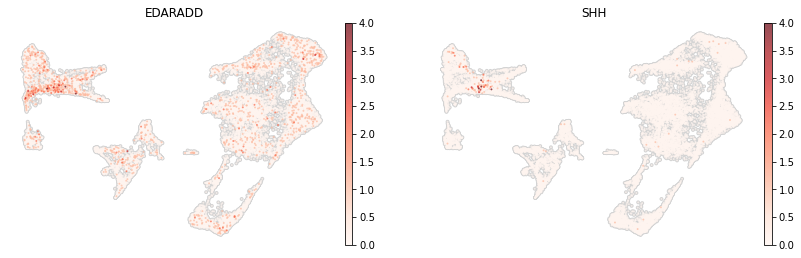

In [6]:
sc.pl.umap(rna_data, color = rna_model.get_top_genes(6, top_n=2), **mira.pref.raw_umap(ncols=3, size=15))

Above, the [mira.pref.raw_umap](../pref/mira.pref.raw_umap.html) function simply provides default values to the Scanpy plotting function to make easily readable plots for normalized expression values.

Let's see what functional enrichments represent these topics. MIRA uses [Enrichr](https://maayanlab.cloud/Enrichr/) to get functional enrichments for each topic by posting the `top_n` genes associated with a topic to their API. You can change the number of genes sent, or output genes sorted in order of activation by the topic for rank-based functional enrichments (like [GSEApy](https://gseapy.readthedocs.io/en/latest/introduction.html)).

To post a topic's top genes to Enrichr, use [post_topic](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.post_topic), or use [post_topics](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.post_topics) to post all topics' lists at once. 

**Note:** A good rule of thumb for setting `top_n` genes is to take the top 5% of genes modeled by the expression topic model. In our case, we modeled ~8000 genes, so I post the top 400 genes:

In [7]:
rna_model.post_topic(6, top_n=400)
rna_model.post_topic(13, top_n=400)

To retreive a sorted list of genes **(least activated to most activated)** for GSEA, use:

In [8]:
rna_model.rank_genes(6)

array(['WBSCR27', 'CCDC148', '4930533K18RIK', ..., 'GINS4', 'EDARADD',
       'SHH'], dtype=object)

To download the enrichment results, run [fetch_topic_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.fetch_topic_enrichments), or similarly run [fetch_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.fetch_enrichments) to download results for all topics. Here, you may provide list of onotologies to compare against. The ontologies available on Enrichr may be found [here](https://maayanlab.cloud/Enrichr/#libraries).

In [9]:
rna_model.fetch_topic_enrichments(6, ontologies= ['WikiPathways_2019_Mouse'])
rna_model.fetch_topic_enrichments(13, ontologies= ['WikiPathways_2019_Mouse','GO_Biological_Process_2018'])

To analyze enrichments, you can use:

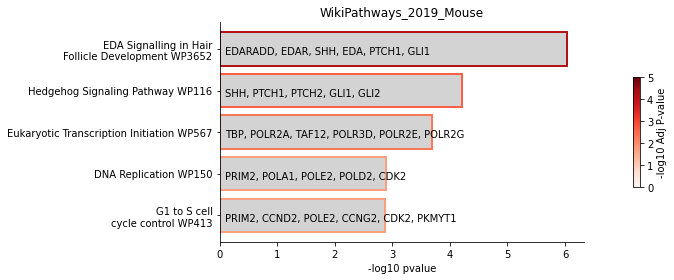

In [10]:
rna_model.plot_enrichments(6, show_top=5)

You can compare enrichments against a pre-compiled list of genes-of-interest, for example, a list of transcription factors, using the `label_genes` parameter. If genes in this list appear in the enrichment plot, they are labeled with a **\***.

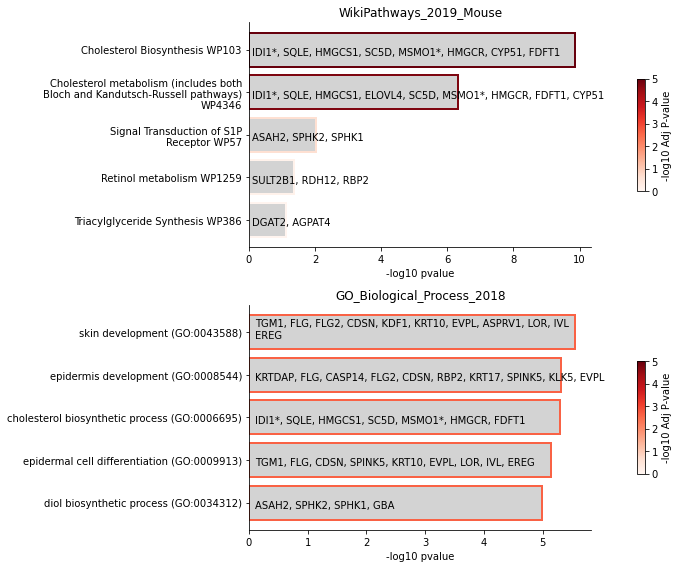

In [11]:
rna_model.plot_enrichments(13, show_top=5, plots_per_row=1,  
                           label_genes=['IDI1','MSMO1'])

For a full list of parameters, see [plot_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.plot_enrichments). You can also access the enrichment data using [get_enrichments](../topicmodeling/mira.topics.ExpressionTopicModel.html#mira.topics.ExpressionTopicModel.get_enrichments):

In [12]:
pd.DataFrame(
    rna_model.get_enrichments(13)['WikiPathways_2019_Mouse']
).head(3)

,rank,term,pvalue,zscore,combined_score,genes,adj_pvalue
0,1,Cholesterol Biosynthesis WP103,1.359165e-10,57.122449,1297.763787,"[IDI1, SQLE, HMGCS1, SC5D, MSMO1, HMGCR, CYP51...",1.005782e-08
1,2,Cholesterol metabolism (includes both Bloch an...,4.738962e-07,11.255754,163.909420,"[IDI1, SQLE, HMGCS1, ELOVL4, SC5D, MSMO1, HMGC...",1.753416e-05
2,3,Signal Transduction of S1P Receptor WP57,9.219927e-03,7.787750,36.496420,"[ASAH2, SPHK2, SPHK1]",2.274249e-01


## Accessibility Topic Analysis

Next, we will find transcription factor enrichments in accessibility topics. First, visualize the cell states represented by some topics:

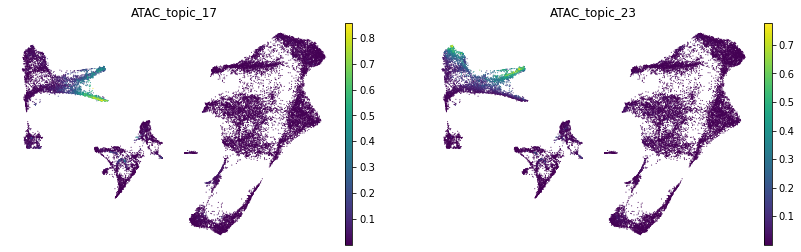

In [13]:
sc.pl.umap(rna_data, color = ['ATAC_topic_17','ATAC_topic_23'], frameon=False, palette='viridis')

ATAC topics 17 and 23 represent two terminal lineages of hair follicle differentiation. It would be interesting to compare and contrast transcription factors influential in these cell states. 

First, we must annotate transcription factor binding sites in our peaks using motif scanning. For this, we need the fasta sequence of the organism's genome. Squences may be downloaded from the [UCSC repository](https://hgdownload.soe.ucsc.edu/downloads.html).

In [14]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.fa.gz
!gzip -d -f mm10.fa.gz

--2022-04-13 14:46:20--  https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870703359 (830M) [application/x-gzip]
Saving to: ‘mm10.fa.gz’

mm10.fa.gz          100%[===================>] 830.37M  8.68MB/s    in 53s     

2022-04-13 14:47:13 (15.8 MB/s) - ‘mm10.fa.gz’ saved [870703359/870703359]



We must also ensure that we indicate the correct columns in the ATAC AnnData object corresponding to the chromosome, start, and end locations of each peak.

In [15]:
atac_data.var.head(3)

,chr,start,end,endogenous
peak_id,,,,
2,chr9,123461850,123462150,True
3,chr1,56782095,56782395,False
4,chr9,56223668,56223968,True


Now, use the function [mira.tl.get_motif_hits_in_peaks](../Tools/mira.tl.get_motif_hits_in_peaks.html), which will scan the sequence of each peak against the JASPAR 2020 vertabrates collection of motifs. Facilities for scanning user-defined motifs and other motif databases will be added in the future.

In [16]:
mira.tools.motif_scan.logger.setLevel(logging.INFO) # make sure progress messages are displayed

mira.tl.get_motif_hits_in_peaks(atac_data, 
                    genome_fasta='mm10.fa', 
                    chrom = 'chr', start = 'start', end = 'end') # indicate chrom, start, end of peaks

INFO:mira.tools.motif_scan:Getting peak sequences ...
334124it [00:34, 9748.27it/s] 
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits 

The function above loads the motif hits into a (n_factors x n_peaks) sparse matrix in `.varm['motif_hits']`, where values are the MOODS3 "Match Score" given a motif PWM and the peak's sequence. All matches that do not meet the p-value threshold were filtered. 

The metadata on the motifs scanned are stored in `.uns['motifs']`, and can be accessed by `mira.utils.fetch_factor_meta`.

In [17]:
mira.utils.fetch_factor_meta(atac_data).head(3)

,id,name,parsed_name
0,MA0397.1,STP4,STP4
1,MA1153.1,SMAD4,SMAD4
2,MA0083.3,SRF,SRF


An AnnData object of motif hits can be accessed with `mira.utils.fetch_motif_hits`:

In [18]:
mira.utils.fetch_factor_hits(atac_data)

AnnData object with n_obs × n_vars = 1646 × 334124
    obs: 'id', 'name', 'parsed_name'
    var: 'chr', 'start', 'end', 'endogenous'

Motif calling often includes many factors that may be irrelevant to the current system. Usually, it is convenient to filter out TFs for which we do not have expression data. Below, we use `mira.utils.subset_factors` to filter out TFs that do not have any associated data in the `rna_data` object (in addition to AP1 since these motifs clog up the plots we're about to make).

**Important: Do not filter out TFs on the basis of mean expression or dispersion, as many TFs can influence cell state without being variably expressed.**

This function marks certain factors as not to be used, but does not remove them from the AnnData. This way, you can use a different filter or include different factors in your analysis without re-calling motifs.

In [19]:
mira.utils.subset_factors(atac_data, 
                          use_factors=[factor for factor in rna_data.var_names 
                                       if not ('FOS' in factor or 'JUN' in factor)])

With motifs called and a trained topic model, we find which motifs are enriched in each topic:

In [20]:
atac_model.get_enriched_TFs(atac_data, topic_num=17, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=23, top_quantile=0.1)

Finding enrichments:   0%|          | 0/528 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/528 [00:00<?, ?it/s]

The parameter of the function above, `top_quantile`, controls what quantile of peaks are taken to represent the topic. Values between 0.1 and 0.2, so the top 10% to 20% peaks, work best. If a certain topic is enriching for non-specific factors, decrease the quantile used to take more topic-specific peaks.

You can retrieve enrichment results using [get_enrichments](../topicmodeling/mira.topics.AccessibilityTopicModel.html#mira.topics.AccessibilityTopicModel.get_enrichments). Note, this list is not sorted:

In [21]:
pd.DataFrame(atac_model.get_enrichments(23)).head(3)

,id,name,parsed_name,pval,test_statistic
0,MA1153.1,SMAD4,SMAD4,4.287406e-01,1.004564
1,MA0083.3,SRF,SRF,9.034861e-01,0.956426
2,MA0907.1,HOXC13,HOXC13,6.261397e-188,1.942430


Comparing and contrasting TF enrichments between topics elucidates common and topic-specific regulators. For this, you can use [plot_compare_topic_enrichments](../topicmodeling/mira.topics.AccessibilityTopicModel.html#mira.topics.AccessibilityTopicModel.plot_compare_topic_enrichments), which plots the -log10 p-value of TF enrichment for one topic vs. another. Below, we see that topic 23 is enriched for homeobox factors, while both topics share enrichment for HOX and WNT factors.

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

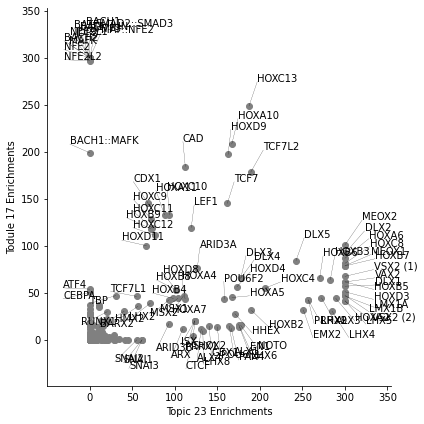

In [22]:
atac_model.plot_compare_topic_enrichments(23, 17,
            fontsize=10, label_closeness=3, figsize=(6,6),
        )

You can color the TFs on the plot to help narrow down import TFs. We could color by expression levels in our cell types of interest:

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

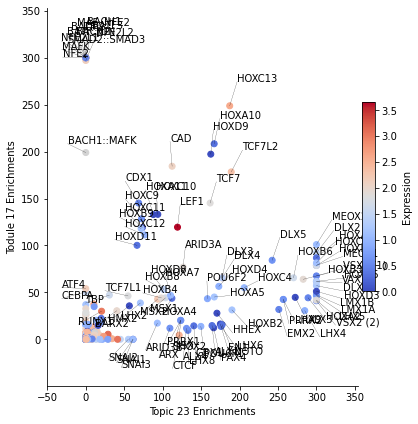

In [23]:
total_expression_in_cells = np.log10(
    np.squeeze(np.array(rna_data[rna_data.obs.true_cell.isin(['Cortex','Medulla'])].X.sum(0))) + 1
)

atac_model.plot_compare_topic_enrichments(23, 17,
            hue = {factor : disp  for factor, disp in zip(rna_data.var_names, total_expression_in_cells)},
            palette = 'coolwarm', legend_label='Expression',
            fontsize=10, label_closeness=3, figsize=(6,6)
        )

To color TFs, pass a dictionary to the `hue` parameter where keys are gene names and values are the associated plotting data. You can pass a dictionary containing any and all genes. When the plotting function needs a color for a TF, it will look up that TF in the dictionary. If a TF is not found, its color will default to the `na_color` parameter.

Guided by domain knowledge and the coloring above, we can highlight certain factors to de-clutter the plot and prepare it for presenting. Below, I pass a list of influential regulators to the `label_factors` parameter.

<AxesSubplot:xlabel='Topic 23 Enrichments', ylabel='Todule 17 Enrichments'>

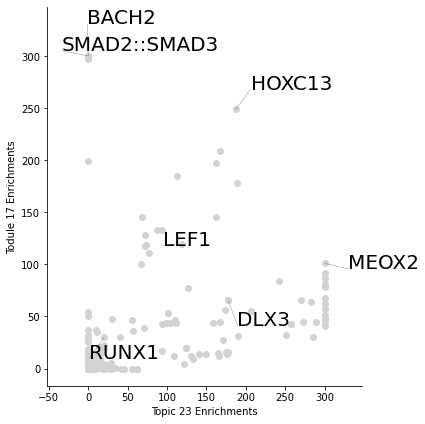

In [24]:
label = ['LEF1','HOXC13','MEOX2','DLX3','BACH2','RUNX1', 'SMAD2::SMAD3']
atac_model.plot_compare_topic_enrichments(23, 17,
            label_factors = label, 
            color = 'lightgrey',
            fontsize=20, label_closeness=5, 
            figsize=(6,6)
        )

## Motif scoring

It can be useful to see in which cell states a certain motif is more accessible/influential than others. You can calculate motif scores, in MIRA's case, the log-probability of sampling a motif-associated accessible region from the posterior predictive distribution over regions from the topic model:

In [25]:
motif_scores = atac_model.get_motif_scores(atac_data)

Imputing features:   0%|          | 0/56 [00:00<?, ?it/s]

Reformat the adata to make it convenient for plotting:

In [26]:
motif_scores.var = motif_scores.var.set_index('parsed_name')
motif_scores.var_names_make_unique()
motif_scores.obsm['X_umap'] = atac_data.obsm['X_umap']

... storing 'name' as categorical


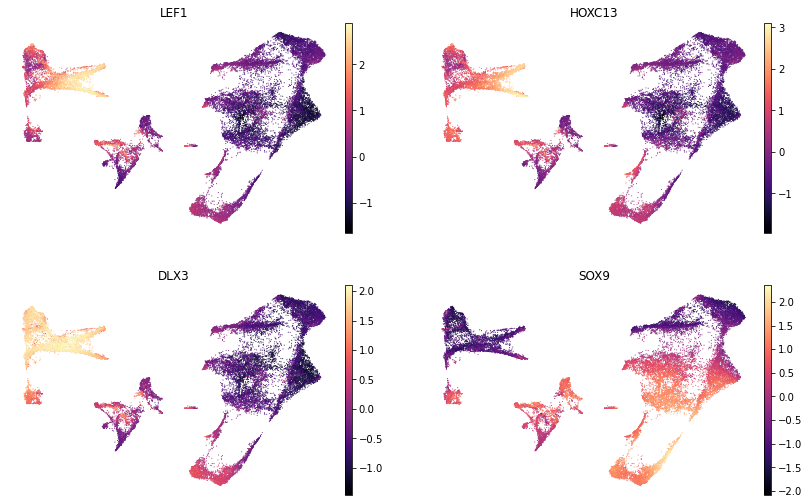

In [27]:
sc.pl.umap(motif_scores, color = ['LEF1', 'HOXC13','DLX3','SOX9'], 
           frameon=False, color_map='magma', ncols=2)

Topic analysis begins to answer questions of which regulators and functional axes determine cell state. In the next tutorial, we will show how topics may be combined with pseudotime trajectory inference to study state dynamics.

## Saving analyses

Enrichment results are saved alongside the topic models. Just save a model with the `save` function, as in the previous tutorial, and next time you load the topic model the enrichment results will be reloaded.

In [34]:
atac_data.write_h5ad('mira-datasets/shareseq_Ma2020/atac_data.joint_representation.motif_calls.h5ad')